In [1]:
!cd .. && mkdir build
!cd ../build/ && rm -rf *
!cd ../build && cmake \
  -DPYTHON_EXECUTABLE="$(which python)" \
  -DCMAKE_BUILD_TYPE=Release ..
!cd ../build && make install

mkdir: cannot create directory ‘build’: File exists
-- The C compiler identification is GNU 9.3.0
-- The CXX compiler identification is GNU 9.3.0
-- Check for working C compiler: /usr/bin/cc
-- Check for working C compiler: /usr/bin/cc -- works
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Detecting C compile features
-- Detecting C compile features - done
-- Check for working CXX compiler: /usr/bin/c++
-- Check for working CXX compiler: /usr/bin/c++ -- works
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Detecting CXX compile features
-- Detecting CXX compile features - done
Release mode
-- Found PythonInterp: /home/dago/anaconda3/bin/python (found version "3.7.6") 
-- Found PythonLibs: /home/dago/anaconda3/lib/libpython3.7m.so
-- pybind11 v2.2.4
-- Performing Test HAS_FLTO
-- Performing Test HAS_FLTO - Success
-- LTO enabled
CMAKE_INSTALL_PREFIX=/home/dago/Desktop/Facultad/MN/MNTp3/tp3
-- Configuring done
-- Generating do

In [2]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# Verifico la correcta instalación. Si no falla el import está OK
!pwd
!python --version
import metnum


/home/dago/Desktop/Facultad/MN/MNTp3/tp3/notebooks
Python 3.7.6


In [4]:
df = pd.read_csv('../data/train.csv')

In [5]:
df = df[df['ciudad']=='Mérida'].dropna()

In [6]:
x = df['metroscubiertos'].values

In [7]:
y = df['precio'].values

In [8]:
x = x.reshape(len(x),1)
y = y.reshape(len(y),1)

In [9]:
x.shape

(518, 1)

In [10]:
from sklearn.linear_model import LinearRegression

"""
Reemplazar por nuestra implementación 
"""

linear_regressor = LinearRegression()
linear_regressor2 = metnum.LinearRegression()

linear_regressor.fit(x,y)
linear_regressor2.fit(x,y)

In [11]:
df['prediction'] = linear_regressor.predict(x)
df['prediction2'] = linear_regressor2.predict(x)

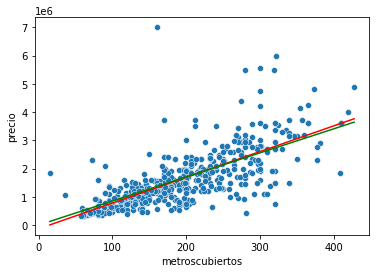

In [12]:
sns.scatterplot(data=df, x='metroscubiertos', y='precio')
sns.lineplot(data=df, x='metroscubiertos', y='prediction', color='red')
sns.lineplot(data=df, x='metroscubiertos', y='prediction2', color='green')
